# Prediction of train demand function in a particular train station 
### Part 1

**Group member:**

Ke Ma, A0212524U

Nanhai Zhong, A0231953E

Mingzhe Xu, A0232022A

Xiao Liang, A0232007X

*Date: 28 Sept*

In [1]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import scipy
import seaborn as sns

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt


# Data Preprocessing

## Unify Date Format

In [2]:
# data was preprocessed in excel to handle date.
df2 = pd.read_csv('./Data-GP1(date).csv')
dept_datetime = pd.to_datetime(df2['Dept_Date'],errors='coerce')
purch_datetime = pd.to_datetime(df2['Purchase_Date'],errors='coerce')
df2['dept_datetime'] = pd.DataFrame(dept_datetime)
df2['purch_datetime'] = pd.DataFrame(purch_datetime)
df = df2.drop(['Dept_Date','Purchase_Date'],axis=1)

In [3]:
df.head()

,num_seats_total,mean_net_ticket_price,Train_Number_All,Culmulative_sales,isNormCabin,isReturn,isOneway,Customer_Cat,dept_datetime,purch_datetime
0,1,188.663422,A,1,1,0,0,A,2010-09-19,2010-10-18
1,1,358.428869,B,1,0,1,0,A,2019-05-27,2006-06-18
2,1,356.372684,B,1,0,1,0,A,2020-05-31,2019-06-17
3,1,396.370505,C,1,0,1,0,A,2012-10-19,2018-12-27
4,1,364.264552,B,2,0,1,0,A,2020-05-31,2019-06-19


In [4]:
df.describe()

,num_seats_total,mean_net_ticket_price,Culmulative_sales,isNormCabin,isReturn,isOneway
count,209697.000000,209697.000000,209697.000000,209697.000000,209697.000000,209697.000000
mean,2.383019,230.116900,15.875063,0.598249,0.480183,0.122873
std,2.083324,147.024784,19.795677,0.490253,0.499608,0.328292
min,1.000000,1.278969,1.000000,0.000000,0.000000,0.000000
25%,1.000000,108.870193,3.000000,0.000000,0.000000,0.000000
50%,2.000000,186.282200,8.000000,1.000000,0.000000,0.000000
75%,3.000000,350.409481,21.000000,1.000000,1.000000,0.000000
max,66.000000,7855.766106,187.000000,1.000000,1.000000,1.000000


## Variables Creation

In [5]:
#Add A New Variable: Gap
df['Gap'] = df['dept_datetime'] - df['purch_datetime']
df['Gap'] = df['Gap'].astype('str').apply(lambda x:x[:-5]).astype('int32')

## Add A New Variable: Price
df['Price'] =  df["mean_net_ticket_price"]/df["num_seats_total"]

# Modify The Variable Name: Quantity
df.rename(columns={'Culmulative_sales':'Quantity'},inplace=True)

# Add A New Variable: isWeekend
from datetime import datetime
minus = pd.DataFrame((df['dept_datetime'] - df['dept_datetime'].min()
              ).astype('str').apply(lambda x: x[:-5]).astype('int32'))

minus['days'] = minus['dept_datetime'] % 7
minus['isWeekend'] = minus['days'].apply(lambda x:1 if x==1 or x==2 else 0)
df['isWeekend'] = minus['isWeekend']

df.head()

,num_seats_total,mean_net_ticket_price,Train_Number_All,Quantity,isNormCabin,isReturn,isOneway,Customer_Cat,dept_datetime,purch_datetime,Gap,Price,isWeekend
0,1,188.663422,A,1,1,0,0,A,2010-09-19,2010-10-18,-29,188.663422,1
1,1,358.428869,B,1,0,1,0,A,2019-05-27,2006-06-18,4726,358.428869,0
2,1,356.372684,B,1,0,1,0,A,2020-05-31,2019-06-17,349,356.372684,1
3,1,396.370505,C,1,0,1,0,A,2012-10-19,2018-12-27,-2260,396.370505,0
4,1,364.264552,B,2,0,1,0,A,2020-05-31,2019-06-19,347,364.264552,1


# Data Screening and Cleaning
### Eliminate Data with Wrong Date

In [6]:
df['dept_datetime'] = pd.to_datetime(df['dept_datetime'])
df['purch_datetime'] = pd.to_datetime(df['purch_datetime'])

df = df[df['purch_datetime'] <= df['dept_datetime']]

### Data exploration

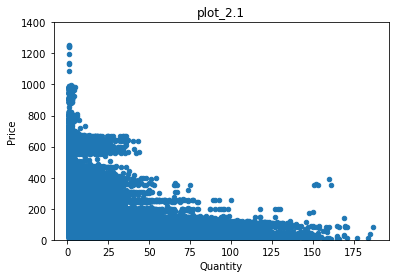

In [7]:
df.plot(x='Quantity',y='Price',kind='scatter')
plt.ylim([0,1400])
plt.title('plot_2.1')
plt.show()

#### Price Jump problem

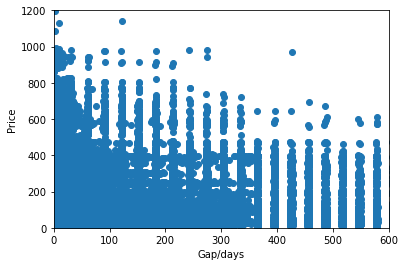

In [8]:
# Prices jump periodically as Gap varies
plt.scatter(df.Gap, df.Price)
plt.ylim(0,1200)
plt.xlim(0,600)
plt.xlabel('Gap/days')
plt.ylabel('Price')
plt.show()

In [9]:
# Furtherly study price concentrate shown above.
jump = df[(df['Price'] > 550) & (df['Gap'] > 240) & (df['Gap'] < 245)].copy()
jump.iloc[:,8:].sort_values(by = 'purch_datetime')[:10]

,dept_datetime,purch_datetime,Gap,Price,isWeekend
162060,2002-06-19,2001-10-19,243,645.674030,0
33578,2002-12-19,2002-04-19,244,593.216741,0
34563,2002-12-19,2002-04-19,244,567.973597,0
11438,2004-07-19,2003-11-19,243,595.543329,0
32926,2004-12-19,2004-04-19,244,684.036729,1
32923,2005-10-19,2005-02-19,242,982.320334,0
32898,2007-10-18,2007-02-18,242,708.453768,0
34164,2007-12-18,2007-04-18,244,559.788705,0
34346,2007-12-18,2007-04-18,244,559.546286,0
192321,2008-09-18,2008-01-18,244,557.086946,0


Prices jump periodically as Gap varies. Furtherly spot that when purchase day and departure day in any month are the same and equals to 18 or 19, this price jump problem happens. So, we create a new variable to deal with this interferrence. 

And data points concentrate regularlly, when Gap > 360 i.e. purchase 1 year before departure.
This is abnormal and consider as mistakes. Who buy train tickets one year before the departure date？

In [10]:
# Drop data with Gap > 360
df = df.drop(df[(df['Gap']>360)].index) 

# Add A New Variable: isdate_1819
df['isdate_1819'] = (df['purch_datetime'] == df['dept_datetime']) 


In [11]:
df1 = df.drop(df[(df['Price']>300) & (df['Quantity']>125)].index) 
df1 = df1.drop(df1[(df1['Price']>1000)].index)

<AxesSubplot:xlabel='isNormCabin', ylabel='Price'>

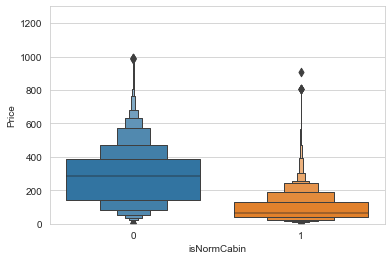

In [12]:
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
ax=sns.boxenplot( df1['isNormCabin'], df1['Price'], data=df1)
ax.set(ylim=(0, 1300))
ax

88866

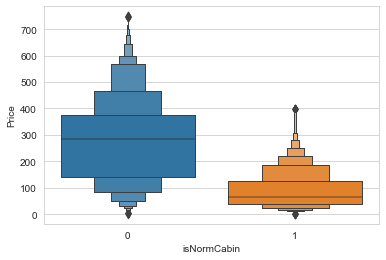

In [13]:
df1 = df1.drop(df1[(df1['Price']>750) & (df1['isNormCabin']==0)].index) 
df1 = df1.drop(df1[(df1['Price']>400) & (df1['isNormCabin']==1)].index) 

sns.set_style("whitegrid")
ax=sns.boxenplot( df1['isNormCabin'], df1['Price'], data=df1)
len(df)

<AxesSubplot:xlabel='isWeekend', ylabel='Price'>

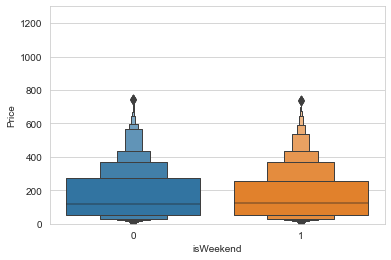

In [14]:
sns.set_style("whitegrid")
ax=sns.boxenplot( df1['isWeekend'], df1['Price'], data=df)
ax.set(ylim=(0, 1300))
ax

<AxesSubplot:xlabel='Customer_Cat', ylabel='Price'>

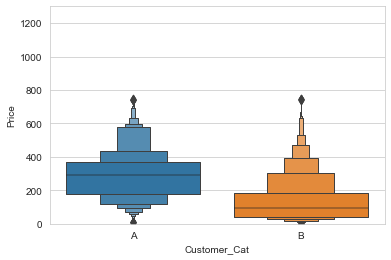

In [15]:
sns.set_style("whitegrid")
ax=sns.boxenplot( df1['Customer_Cat'], df1['Price'], data=df1)
ax.set(ylim=(0, 1300))
ax

### Data Cleaning

In [16]:
df1 = df.copy()
df1 = df1.drop(df1[(df1['Gap']>360)].index) 
df1 = df1.drop(df1[(df1['Price']>300) & (df1['Quantity']>125)].index) 
df1 = df1.drop(df1[(df1['Price']>1000)].index)
df1 = df1.drop(df1[(df1['Price']>750) & (df1['isNormCabin']==0)].index) 
df1 = df1.drop(df1[(df1['Price']>400) & (df1['isNormCabin']==1)].index) 
df1 = df1.drop(df1[(df1['Price']>650) & (df1['Customer_Cat']=='B')].index) 
df1 = df1.drop(df1[(df1['Price']>700) & (df1['Customer_Cat']=='A')].index)
df = df1
df.head()

,num_seats_total,mean_net_ticket_price,Train_Number_All,Quantity,isNormCabin,isReturn,isOneway,Customer_Cat,dept_datetime,purch_datetime,Gap,Price,isWeekend,isdate_1819
2,1,356.372684,B,1,0,1,0,A,2020-05-31,2019-06-17,349,356.372684,1,False
4,1,364.264552,B,2,0,1,0,A,2020-05-31,2019-06-19,347,364.264552,1,False
5,1,318.300419,D,1,0,1,0,A,2020-05-23,2019-06-20,338,318.300419,1,False
6,2,464.010928,E,2,0,1,0,A,2019-05-23,2018-06-20,337,232.005464,0,False
7,1,355.221623,C,1,0,1,0,A,2019-10-18,2018-11-15,337,355.221623,0,False


### Output cleaned data

In [17]:
# output
df.to_csv('cleaned_data.csv')

## Correlation Analysis Between Customer_Cat and Other Variables

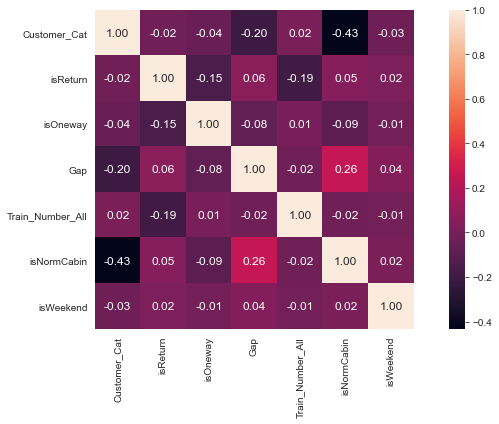

In [18]:
import seaborn as sns
df2 = df
df2['Customer_Cat'] = pd.get_dummies(df2['Customer_Cat'])
df2['Train_Number_All'] = pd.get_dummies(df2['Train_Number_All'])

cols = [
    'Customer_Cat', 'isReturn', 'isOneway', 'Gap', 'Train_Number_All',
    'isNormCabin', 'isWeekend'
]

cm = np.corrcoef(df2[cols].values.T)
#sns.set(font_scale=1.5) 

plt.figure(figsize=(10,6))

hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 yticklabels=cols,
                 xticklabels=cols)

# plt.savefig('heatmap.png', dpi=300)
plt.tight_layout()
plt.show()